In [10]:
# ===== Imports =====

import zipfile
import gzip
import json
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np

In [11]:
# ===== Path definition =====
ZIP_PATH = Path("dota_games.zip")


In [12]:
# ===== Overview of data in the zip file =====

with zipfile.ZipFile(ZIP_PATH) as z:
    all_names = z.namelist()

len(all_names), all_names[:20]

(2338044,
 ['dota_games/',
  'dota_games/5607724594.json',
  'dota_games/5647502064.json',
  'dota_games/5670735120.json',
  'dota_games/5657129776.json',
  'dota_games/5619512449.json',
  'dota_games/5607707456.json',
  'dota_games/5675658398.json',
  'dota_games/5640308337.json',
  'dota_games/5668785092.json',
  'dota_games/5675202442.json',
  'dota_games/5652180245.json',
  'dota_games/5619281841.json',
  'dota_games/5643104662.json',
  'dota_games/5637745359.json',
  'dota_games/5611590380.json',
  'dota_games/5626491048.json',
  'dota_games/5669252981.json',
  'dota_games/5630331346.json',
  'dota_games/5675209951.json'])

In [13]:
# ===== Datatypes / Endings of files =====
ext_counter = Counter(Path(name).suffix for name in all_names)
ext_counter

Counter({'.json': 2338043, '': 1})

In [14]:
# ===== Helper function to load match data =====

def load_match_from_zip(zip_path: Path, inner_name: str):
    """
    Loads one match JSON from a zip file, handling gzipped files if necessary.
    Returns the match data as a dictionary.
    """
    with zipfile.ZipFile(zip_path) as z:
        with z.open(inner_name) as f:
            # Falls gzipped JSON:
            if inner_name.endswith(".gz"):
                with gzip.GzipFile(fileobj=f) as gz:
                    data = json.load(gz)
            else:
                data = json.load(f)
    
    # Many dumps have the pattern {"result": {...}} – if so, extract the match object:
    if isinstance(data, dict) and "result" in data and isinstance(data["result"], dict):
        return data["result"]
    return data

In [15]:
# ===== Load and Inspect one example match =====

example_name = next(n for n in all_names if n.endswith(".json") or n.endswith(".json.gz"))

match = load_match_from_zip(ZIP_PATH, example_name)
type(match), list(match.keys())[:30]

(dict,
 ['players',
  'radiant_win',
  'duration',
  'pre_game_duration',
  'start_time',
  'match_id',
  'match_seq_num',
  'tower_status_radiant',
  'tower_status_dire',
  'barracks_status_radiant',
  'barracks_status_dire',
  'cluster',
  'first_blood_time',
  'lobby_type',
  'human_players',
  'leagueid',
  'positive_votes',
  'negative_votes',
  'game_mode',
  'flags',
  'engine',
  'radiant_score',
  'dire_score',
  'picks_bans'])

In [16]:
# ===== Choose sample-data for further analysis =====

N_SAMPLE = 50  # number of matches to load for analysis
json_like = [n for n in all_names if n.endswith(".json") or n.endswith(".json.gz")]

print(len(json_like))

# ===== Load N_SAMPLE matches =====

sample_matches = []
for name in json_like[:N_SAMPLE]:
    try:
        m = load_match_from_zip(ZIP_PATH, name)
        sample_matches.append(m)
    except Exception as e:
        print("Error loading", name, ":", e)

len(sample_matches)

2338043


50

In [17]:
# ===== Frequency of match-fields =====

field_counts = Counter()
for m in sample_matches:
    field_counts.update(m.keys())

field_counts.most_common(40)

[('players', 50),
 ('radiant_win', 50),
 ('duration', 50),
 ('pre_game_duration', 50),
 ('start_time', 50),
 ('match_id', 50),
 ('match_seq_num', 50),
 ('tower_status_radiant', 50),
 ('tower_status_dire', 50),
 ('barracks_status_radiant', 50),
 ('barracks_status_dire', 50),
 ('cluster', 50),
 ('first_blood_time', 50),
 ('lobby_type', 50),
 ('human_players', 50),
 ('leagueid', 50),
 ('positive_votes', 50),
 ('negative_votes', 50),
 ('game_mode', 50),
 ('flags', 50),
 ('engine', 50),
 ('radiant_score', 50),
 ('dire_score', 50),
 ('picks_bans', 50)]

In [18]:
# ===== Player-field analysis =====

player_field_counts = Counter()
players_per_match = []

for m in sample_matches:
    players = m.get("players", [])
    players_per_match.append(len(players))
    for p in players:
        if isinstance(p, dict):
            player_field_counts.update(p.keys())

players_per_match[:20], np.mean(players_per_match), player_field_counts.most_common(30)

([10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10],
 np.float64(10.0),
 [('account_id', 500),
  ('player_slot', 500),
  ('hero_id', 500),
  ('item_0', 500),
  ('item_1', 500),
  ('item_2', 500),
  ('item_3', 500),
  ('item_4', 500),
  ('item_5', 500),
  ('backpack_0', 500),
  ('backpack_1', 500),
  ('backpack_2', 500),
  ('item_neutral', 500),
  ('kills', 500),
  ('deaths', 500),
  ('assists', 500),
  ('leaver_status', 500),
  ('last_hits', 500),
  ('denies', 500),
  ('gold_per_min', 500),
  ('xp_per_min', 500),
  ('level', 500),
  ('hero_damage', 500),
  ('tower_damage', 500),
  ('hero_healing', 500),
  ('gold', 500),
  ('gold_spent', 500),
  ('scaled_hero_damage', 500),
  ('scaled_tower_damage', 500),
  ('scaled_hero_healing', 500)])

In [19]:
# DataFrame with easy match features =====

def extract_match_row(m: dict):
    return {
        "match_id": m.get("match_id"),
        "radiant_win": m.get("radiant_win"),
        "duration": m.get("duration"),
        "start_time": m.get("start_time"),
        "game_mode": m.get("game_mode"),
        "lobby_type": m.get("lobby_type"),
        "human_players": m.get("human_players"),
        "radiant_score": m.get("radiant_score"),
        "dire_score": m.get("dire_score"),
    }

match_rows = [extract_match_row(m) for m in sample_matches]
df_matches = pd.DataFrame(match_rows)

df_matches.head()

,match_id,radiant_win,duration,start_time,game_mode,lobby_type,human_players,radiant_score,dire_score
0,5607724594,False,2407,1599707329,3,7,10,22,32
1,5647502064,True,1929,1602101175,22,7,10,45,32
2,5670735120,False,1946,1603578371,22,7,10,31,59
3,5657129776,True,1547,1602726380,22,7,10,33,7
4,5619512449,False,1729,1600418403,3,7,10,22,42


In [20]:
# ===== Overview of match-features =====

df_matches.describe(include="all")

,match_id,radiant_win,duration,start_time,game_mode,lobby_type,human_players,radiant_score,dire_score
count,5.000000e+01,50,50.000000,5.000000e+01,50.000000,50.0,50.0,50.00000,50.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.644664e+09,NaN,1940.620000,1.601956e+09,19.340000,7.0,10.0,29.86000,29.560000
std,2.177465e+07,NaN,380.859495,1.343728e+06,6.659687,0.0,0.0,12.28407,12.086694
min,5.603488e+09,NaN,925.000000,1.599446e+09,3.000000,7.0,10.0,5.00000,4.000000
25%,5.627936e+09,NaN,1681.000000,1.600901e+09,22.000000,7.0,10.0,21.25000,20.000000
50%,5.648261e+09,NaN,1930.000000,1.602150e+09,22.000000,7.0,10.0,30.50000,30.500000
75%,5.660182e+09,NaN,2239.750000,1.602921e+09,22.000000,7.0,10.0,35.75000,35.750000


In [21]:
# ===== Winrate Radiant vs. Dire (in sample) =====

radiant_win_rate = df_matches["radiant_win"].mean()
radiant_win_rate, 1 - radiant_win_rate

(np.float64(0.44), np.float64(0.56))

In [22]:
# ===== Distribution of game duration (in minutes) =====

df_matches["duration_min"] = df_matches["duration"] / 60
df_matches["duration_min"].describe()

count    50.000000
mean     32.343667
std       6.347658
min      15.416667
25%      28.016667
50%      32.166667
75%      37.329167
max      47.600000
Name: duration_min, dtype: float64

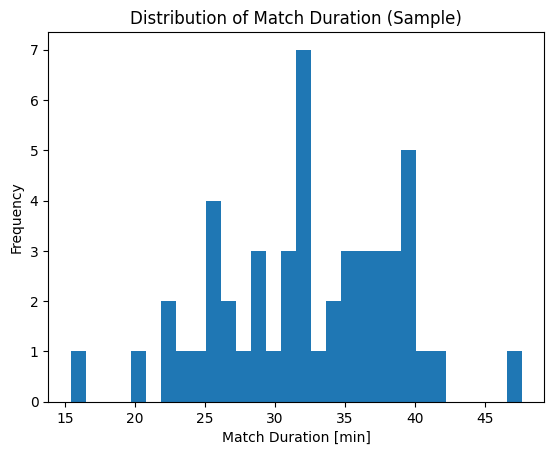

In [23]:
# ===== Histogram of game durations =====

import matplotlib.pyplot as plt

plt.hist(df_matches["duration_min"].dropna(), bins=30)
plt.xlabel("Match Duration [min]")
plt.ylabel("Frequency")
plt.title("Distribution of Match Duration (Sample)")
plt.show()

In [24]:
# ===== Folder structure / "datasets" =====

folder_counter = Counter(str(Path(name).parent) for name in json_like)
folder_counter.most_common(30)

[('dota_games', 2338043)]

In [25]:
# ===== Example: per "underlaying dataset" one sample count =====

dataset_stats = {}

with zipfile.ZipFile(ZIP_PATH) as z:
    for folder, _count in folder_counter.most_common():
        # alle JSON-Dateien in diesem Ordner
        files = [n for n in json_like if str(Path(n).parent) == folder]
        dataset_stats[folder] = len(files)

dataset_stats

{'dota_games': 2338043}

In [26]:
# ===== Example: Hero-IDs and picks_bans count =====

has_picks_bans = 0
hero_id_counter = Counter()

for m in sample_matches:
    # player heroes
    for p in m.get("players", []):
        hid = p.get("hero_id")
        if hid is not None:
            hero_id_counter[hid] += 1
    
    if "picks_bans" in m and m["picks_bans"]:
        has_picks_bans += 1

has_picks_bans, len(sample_matches), hero_id_counter.most_common(10)

(50,
 50,
 [(14, 16),
  (9, 14),
  (84, 12),
  (41, 11),
  (44, 11),
  (106, 10),
  (74, 10),
  (8, 10),
  (31, 9),
  (67, 9)])